# Learned Analytical Formula for Edge Probability Estimation

This notebook learns an improved analytical function that generalizes across sparse and dense graphs.

## Approach

1. Train parameterized analytical function on N permutations
2. Validate against 200-permutation empirical frequencies
3. Find minimum N where performance converges
4. Save optimized predictions for all edges

## Parameterized Formula

```
P(u, v | graph) = α × (u^β × v^γ) / (δ + ε×m + ζ×(u×v)^η + θ×density^κ)
```

Where α, β, γ, δ, ε, ζ, η, θ, κ are learned parameters.

In [9]:
# Papermill parameters
edge_type = "AeG"  # Edge type to analyze
N_candidates = [2, 3, 5, 7, 10, 15, 20, 30, 40, 50]  # Permutation counts to test
convergence_threshold = 0.0001  # Stop if improvement < 2%
target_metric = "correlation"  # Metric to optimize
min_metric_value = 0.9999  # Target performance level

# Handle string-to-list conversion for N_candidates (from papermill)
import json
if isinstance(N_candidates, str):
    N_candidates = json.loads(N_candidates)

## Setup

In [10]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd().parent
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
results_dir = repo_dir / 'results'

sys.path.append(str(src_dir))

# Import custom module
from learned_analytical import LearnedAnalyticalFormula

print("All modules imported successfully!")
print(f"Repository directory: {repo_dir}")
print(f"Analyzing edge type: {edge_type}")
print(f"Testing N values: {N_candidates}")

All modules imported successfully!
Repository directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability
Analyzing edge type: AeG
Testing N values: [2, 3, 5, 7, 10, 15, 20, 30, 40, 50]


## Find Minimum Permutations

In [11]:
# Initialize learner
learner = LearnedAnalyticalFormula()

# Find minimum permutations
results = learner.find_minimum_permutations(
    graph_name=edge_type,
    data_dir=data_dir,
    results_dir=results_dir,
    N_candidates=N_candidates,
    convergence_threshold=convergence_threshold,
    target_metric=target_metric,
    min_metric_value=min_metric_value
)

FINDING MINIMUM PERMUTATIONS FOR AeG
Testing N values: [2, 3, 5, 7, 10, 15, 20, 30, 40, 50]
Target: correlation > 0.9999
Convergence threshold: 0.0001 (0.01%)

Loading 200-permutation empirical frequencies (validation target)...
  Degree combinations: 13167

  Zero-degree node filtering:
    Removed 161 sources and 2851 targets with degree=0
    Retained: 241 sources × 18094 targets
    Density: 0.062519 → 0.120717 (1.9x increase)

Graph statistics:
  Edges (m): 526407
  Density: 0.1207
  Nodes: 241 × 18094

--------------------------------------------------------------------------------
Training with N = 2 permutations
--------------------------------------------------------------------------------

Results for N = 2:
  Optimization: ✓ Success (44 iterations)
  Training:
    MAE: 0.067456
    Correlation: 0.963492
  Validation (vs 200-perm empirical):
    MAE: 0.053528
    RMSE: 0.082233
    Correlation: 0.976635

-----------------------------------------------------------------------

## Results Summary

In [12]:
print(f"\n{'='*80}")
print(f"FINAL RESULTS FOR {edge_type}")
print(f"{'='*80}")
print(f"\nMinimum permutations: N = {results['N_min']}")
print(f"\nLearned parameters:")
param_names = ['α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'κ']
for name, value in zip(param_names, results['best_params']):
    print(f"  {name} = {value:.6f}")

print(f"\nValidation metrics (vs 200-perm empirical):")
for metric, value in results['final_metrics'].items():
    print(f"  {metric}: {value:.6f}")

print(f"\nBaseline (current analytical):")
for metric, value in results['baseline_metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Calculate improvements
mae_improv = (results['baseline_metrics']['mae'] - results['final_metrics']['mae']) / results['baseline_metrics']['mae'] * 100
corr_improv = (results['final_metrics']['correlation'] - results['baseline_metrics']['correlation']) / results['baseline_metrics']['correlation'] * 100

print(f"\nImprovement:")
print(f"  MAE: {mae_improv:+.2f}%")
print(f"  Correlation: {corr_improv:+.2f}%")
print(f"{'='*80}")


FINAL RESULTS FOR AeG

Minimum permutations: N = 3

Learned parameters:
  α = 0.129662
  β = 0.637950
  γ = 1.091539
  δ = 0.001000
  ε = 0.006113
  ζ = 0.234142
  η = 0.500000
  θ = 0.000000
  κ = 0.100000

Validation metrics (vs 200-perm empirical):
  mae: 0.053476
  rmse: 0.082249
  r2: 0.952317
  correlation: 0.976606

Baseline (current analytical):
  mae: 0.093728
  rmse: 0.153389
  r2: 0.834161
  correlation: 0.959780

Improvement:
  MAE: +42.95%
  Correlation: +1.75%


## Generate Predictions for All Edges

In [13]:
print(f"Generating predictions for all source-target combinations...")
predictions_df = learner.predict_all_edges(edge_type, data_dir)

print(f"\nPredictions generated:")
print(f"  Total combinations: {len(predictions_df):,}")
print(f"  Learned probability range: {predictions_df['learned_probability'].min():.6f} - {predictions_df['learned_probability'].max():.6f}")
print(f"  Analytical probability range: {predictions_df['analytical_probability'].min():.6f} - {predictions_df['analytical_probability'].max():.6f}")

# Display sample
print(f"\nSample predictions:")
print(predictions_df.head(10).to_string(index=False))

Generating predictions for all source-target combinations...

  Zero-degree node filtering:
    Removed 161 sources and 2851 targets with degree=0
    Retained: 241 sources × 18094 targets
    Density: 0.062519 → 0.120717 (1.9x increase)

Predictions generated:
  Total combinations: 4,360,654
  Learned probability range: 0.000040 - 1.000000
  Analytical probability range: 0.000002 - 0.944747

Sample predictions:
 source_index  target_index  source_degree  target_degree  learned_probability  analytical_probability
            0             0           7939             20             0.316791                0.292834
            0             1           7939             75             1.000000                0.754208
            0             2           7939             38             0.631594                0.502955
            0             3           7939              5             0.070756                0.076339
            0             4           7939             13            

## Save Results

In [14]:
# Create output directory
output_dir = results_dir / 'learned_analytical' / f'{edge_type}_results'
output_dir.mkdir(parents=True, exist_ok=True)

# Save learned parameters and metrics
learner.save_results(results, output_dir)

# Save predictions
predictions_file = output_dir / f'{edge_type}_learned_predictions.csv'
predictions_df.to_csv(predictions_file, index=False)
print(f"\nPredictions saved to: {predictions_file}")

# Save compressed version
predictions_file_gz = output_dir / f'{edge_type}_learned_predictions.csv.gz'
predictions_df.to_csv(predictions_file_gz, index=False, compression='gzip')
print(f"Compressed predictions saved to: {predictions_file_gz}")

# Save convergence data
convergence_df = pd.DataFrame([
    {
        'N': r['N'],
        'train_mae': r['train_metrics']['mae'],
        'train_rmse': r['train_metrics']['rmse'],
        'train_correlation': r['train_metrics']['correlation'],
        'val_mae': r['val_metrics']['mae'],
        'val_rmse': r['val_metrics']['rmse'],
        'val_correlation': r['val_metrics']['correlation']
    }
    for r in results['convergence_curve']
])

convergence_file = output_dir / f'{edge_type}_convergence_data.csv'
convergence_df.to_csv(convergence_file, index=False)
print(f"Convergence data saved to: {convergence_file}")

print(f"\n{'='*80}")
print(f"ALL RESULTS SAVED TO: {output_dir}")
print(f"{'='*80}")

Parameters saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_learned_parameters.json
Metrics saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_metrics.json

Predictions saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_learned_predictions.csv
Compressed predictions saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_learned_predictions.csv.gz
Convergence data saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_convergence_data.csv

ALL RESULTS SAVED TO: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results


## Visualization: Learned vs Analytical vs Empirical

Matched 4220078 degree combinations

Comparison plot saved to: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_learned_vs_analytical_comparison.png


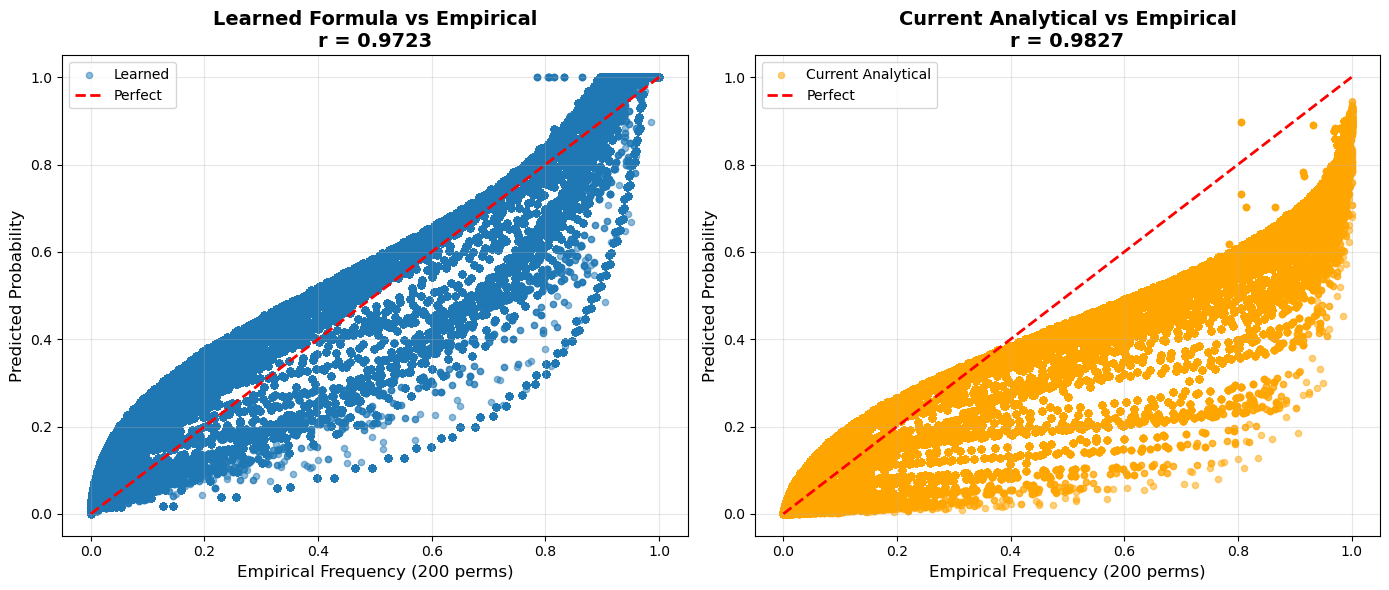

In [15]:
# Load empirical frequencies
empirical_file = results_dir / 'empirical_edge_frequencies' / f'edge_frequency_by_degree_{edge_type}.csv'
empirical_df = pd.read_csv(empirical_file)

# Merge with predictions
comparison_df = empirical_df.merge(
    predictions_df,
    on=['source_degree', 'target_degree'],
    how='inner'
)

print(f"Matched {len(comparison_df)} degree combinations")

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Learned vs Empirical
axes[0].scatter(comparison_df['frequency'], comparison_df['learned_probability'], 
                alpha=0.5, s=20, label='Learned')
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect')
corr_learned = np.corrcoef(comparison_df['frequency'], comparison_df['learned_probability'])[0, 1]
axes[0].set_xlabel('Empirical Frequency (200 perms)', fontsize=12)
axes[0].set_ylabel('Predicted Probability', fontsize=12)
axes[0].set_title(f'Learned Formula vs Empirical\nr = {corr_learned:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Analytical vs Empirical
axes[1].scatter(comparison_df['frequency'], comparison_df['analytical_probability'], 
                alpha=0.5, s=20, label='Current Analytical', color='orange')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect')
corr_analytical = np.corrcoef(comparison_df['frequency'], comparison_df['analytical_probability'])[0, 1]
axes[1].set_xlabel('Empirical Frequency (200 perms)', fontsize=12)
axes[1].set_ylabel('Predicted Probability', fontsize=12)
axes[1].set_title(f'Current Analytical vs Empirical\nr = {corr_analytical:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
comparison_plot = output_dir / f'{edge_type}_learned_vs_analytical_comparison.png'
plt.savefig(comparison_plot, dpi=300, bbox_inches='tight')
print(f"\nComparison plot saved to: {comparison_plot}")
plt.show()

## Summary Statistics

In [16]:
print(f"\n{'='*80}")
print(f"SUMMARY FOR {edge_type}")
print(f"{'='*80}")
print(f"\nGraph characteristics:")
print(f"  Total edges: {results['graph_stats']['m']:,}")
print(f"  Density: {results['graph_stats']['density']:.4f}")
print(f"  Nodes: {results['graph_stats']['n_sources']} × {results['graph_stats']['n_targets']}")

print(f"\nOptimization:")
print(f"  Minimum permutations: {results['N_min']}")
print(f"  Convergence threshold: {convergence_threshold} ({convergence_threshold*100}%)")
print(f"  Target metric: {target_metric} > {min_metric_value}")

print(f"\nPerformance (vs 200-perm empirical):")
print(f"  Learned:    MAE={results['final_metrics']['mae']:.6f}, r={results['final_metrics']['correlation']:.6f}")
print(f"  Analytical: MAE={results['baseline_metrics']['mae']:.6f}, r={results['baseline_metrics']['correlation']:.6f}")
print(f"  Improvement: MAE {mae_improv:+.1f}%, Correlation {corr_improv:+.1f}%")

print(f"\nOutput files:")
print(f"  Parameters: {output_dir / f'{edge_type}_learned_parameters.json'}")
print(f"  Metrics: {output_dir / f'{edge_type}_metrics.json'}")
print(f"  Predictions: {output_dir / f'{edge_type}_learned_predictions.csv.gz'}")
print(f"  Convergence: {output_dir / f'{edge_type}_convergence_curve.png'}")
print(f"{'='*80}")


SUMMARY FOR AeG

Graph characteristics:
  Total edges: 526,407
  Density: 0.1207
  Nodes: 241 × 18094

Optimization:
  Minimum permutations: 3
  Convergence threshold: 0.0001 (0.01%)
  Target metric: correlation > 0.9999

Performance (vs 200-perm empirical):
  Learned:    MAE=0.053476, r=0.976606
  Analytical: MAE=0.093728, r=0.959780
  Improvement: MAE +42.9%, Correlation +1.8%

Output files:
  Parameters: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_learned_parameters.json
  Metrics: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_metrics.json
  Predictions: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_learned_predictions.csv.gz
  Convergence: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/results/learned_analytical/AeG_results/AeG_con